In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
import numpy.ma as ma

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16

In [2]:
#random trigger data
ptrigDF = pd.read_pickle(r'Cosmic_Runs_Run37_list.pkl')
#cosmic data
cosmic_df = pd.read_pickle(r'COSMIC_LG50_HG50_4k_R36.pkl')

#set to 1 for 4k files, 2 for 8k files
ADCmult = 1

#All hits below this threshold are set to zero
MIPCut = 0.3

#Apply MIP scaling and pedestal ADC value here for simulation

#ADCs per MIP for simulation, set to 1 if the file is in units of MIPs
ADCtoMIP = 1

#Pedestal value for simulation, in whatever units the file is in
SimPedestal = 0

simPedMeans = np.full(40, SimPedestal)
simMips = np.full(40, ADCtoMIP)

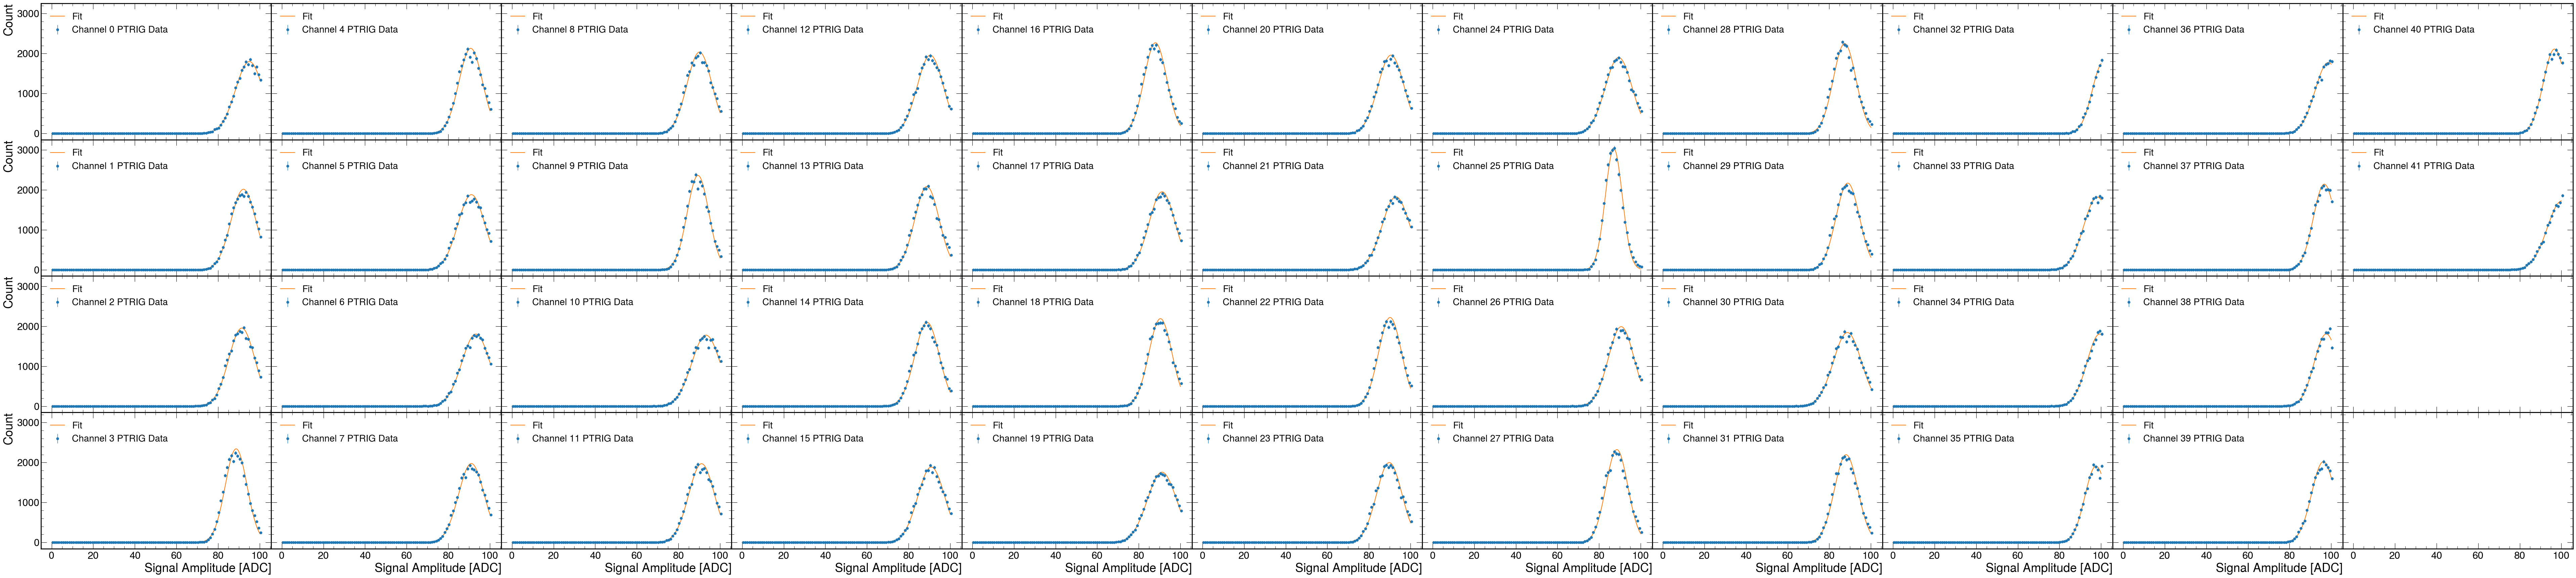

In [3]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 11, figsize=(0.9*len(cosmic_df.columns),17),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    #u = (x - mu)*3.591/(sigma/2.355)
    #Aprime = 1.648*A
    #return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

pedMeans = []
pedStds = []

for i in range(42):
    plt.sca(axs[i%4][i//4])
    
    h = hist.Hist(hist.axis.Regular(100, 0, 101, name="Ptrig"))
    h.fill(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))))
    #h.plot(color='blue',label=f"Channel {i} PTRIG Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} PTRIG Data")

    # Initial parameter values for the fit
    initial_params = [max(h), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 3.]
    #initial_params = [10000,43,2.5]
    # Create Minuit object and set up the fit
    #new code below
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    m = Minuit(LeastSquares(x, y, yerr, gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    x = np.linspace(0, 100, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper left', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
  
    #plt.yscale("log") 
    
    pedMeans.append(mu_fit)
    pedStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Average mean value:
92.16998634051411
Average width value:
5.975252445276317
[94.98885022174014, 92.15355186619834, 91.34816880589348, 88.62993309705664, 90.75814987126566, 91.08540110430877, 93.23072060259655, 91.06946130970259, 90.09317707002535, 89.38714796698419, 93.22110499096543, 91.10738624101087, 90.41894285199058, 88.78857281440685, 88.84254934003062, 90.87690025857134, 87.99785750184681, 91.21083800018303, 90.39341144779135, 91.14140287495894, 90.59443907216425, 92.99540110174345, 90.14452763157088, 89.76150553269197, 89.40059392033389, 87.06499720652124, 90.60825432217987, 88.54256775722844, 87.38701485917215, 88.88446544855765, 88.70494725031779, 88.10032473250712, 100.97800452078134, 98.17121670207099, 99.34664083958397, 97.58284194037319, 98.62647580172558, 96.69991339343227, 97.61823895808699, 96.23663799876574, 96.71127921535702, 100.2356098588995]
[6.673856202620437, 6.02677413372395, 6.255316885994332, 5.240439512804042, 5.682315835757267, 6.486439573130268, 6.7518918

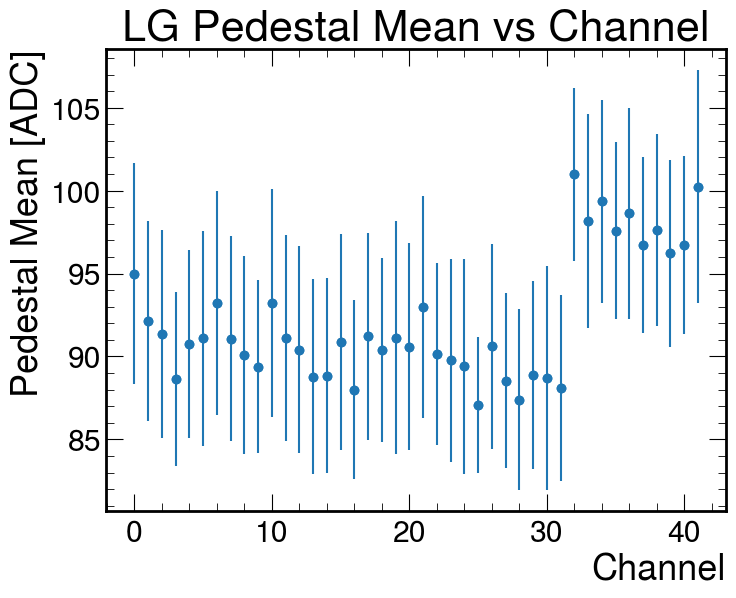

In [4]:
#plot pedestals means and stds for low gain

fig = plt.figure( figsize=(8, 6))
plt.scatter(range(0,42),pedMeans)
plt.xlabel('Channel')
plt.ylabel('Pedestal Mean [ADC]')
plt.title("LG Pedestal Mean vs Channel")
plt.errorbar(range(0,42), pedMeans, yerr=pedStds, fmt="o")
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))
#new codes below
print(pedMeans)
print(pedStds)

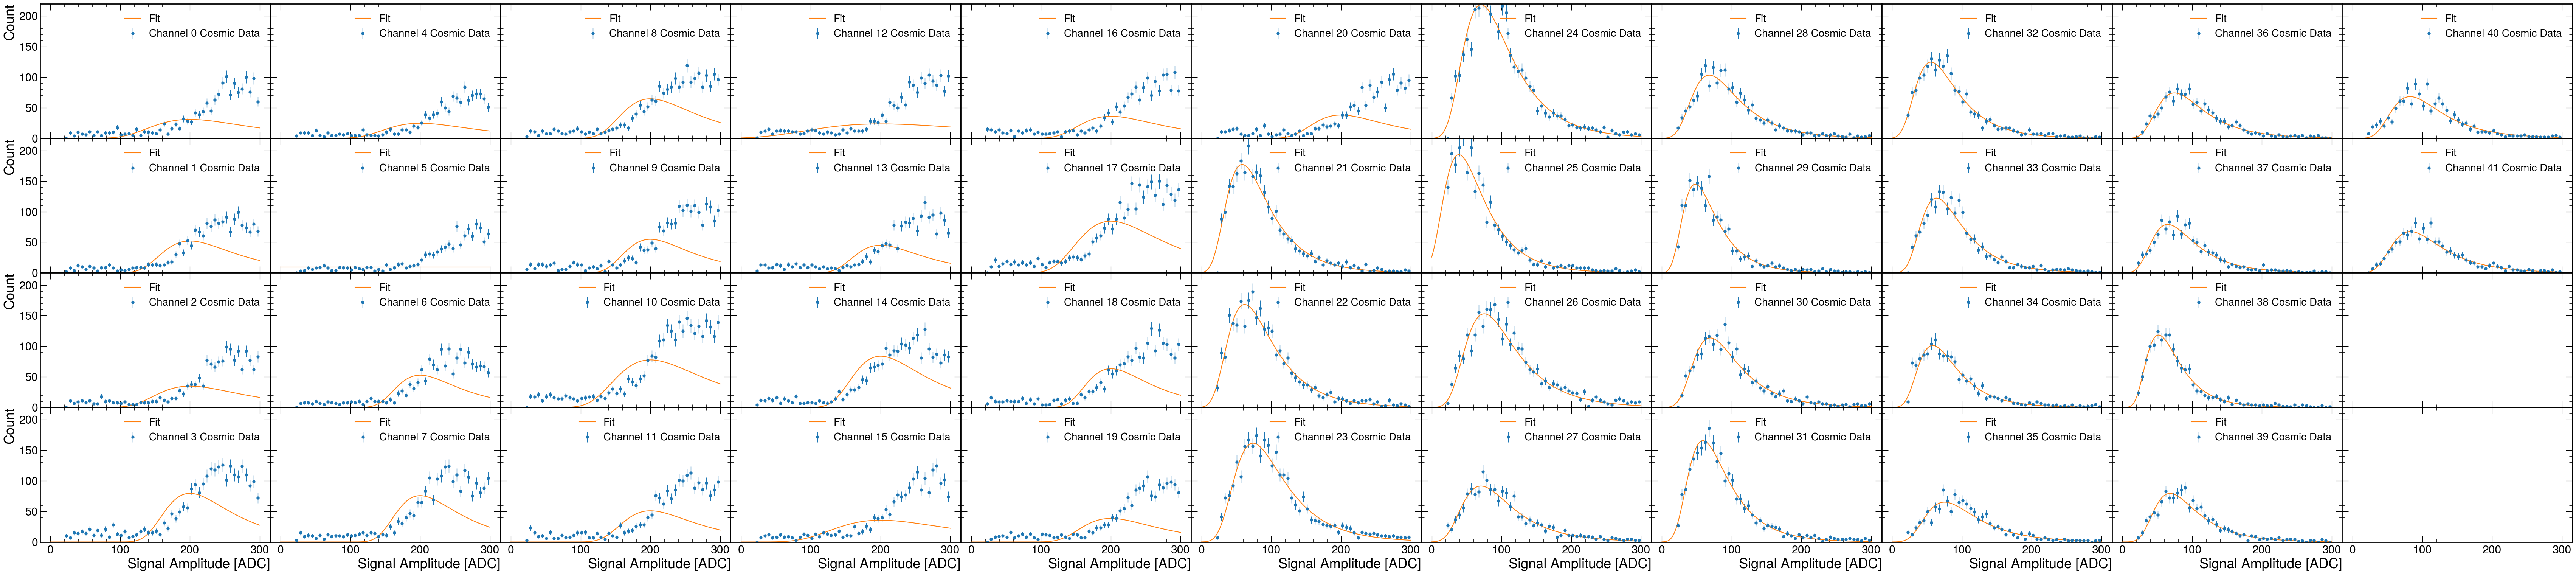

In [11]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later. 
#this is with boards 1,2,3,12,13,14 hexagon w/ 7 cells

fig, axs=plt.subplots(4, 11, figsize=(0.8*len(cosmic_df.columns),15),sharey=True,sharex=True)
#fig, axs = plt.subplots(4, 6, figsize=(15, 10), sharey=True, sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

mips = []
mipStds = []

def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

    #mips = []
    #mipStds = []

for i in range(42):
    cosmicCh = np.array(getattr(cosmic_df, "Ch_{}_LG".format("{:02d}".format(i))))
    cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] * 4) + pedMeans[i]] - pedMeans[i]
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 20, 300, name="Ptrig"))
    
    #print(cosmicCh)
  #the logic of the cut is that the cosmic chanel has to be less than or equal to the (ped standard X 4) plus the ped means @index i - pedmeans @index i
   #here is an array
    
    
    h.fill(cosmicCh)
    #plt.errorbar(bins, data, yerr=np.sqrt(data), fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0, label=f"Channel {i} Cosmic Data")
    #h.plot(color='tab:blue',label=f"Channel {i} Cosmic Data")  #comment
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")

    
    # Find the bin number with the maximum value
    max_bin_number = np.argmax(h.values())

    # Get the axis from the histogram
    axis = h.axes[0]

    # Find the x-coordinate corresponding to the maximum bin
    x_coordinate = axis.edges[max_bin_number]
    mips.append(x_coordinate)
    
    # Initial parameter values for the fit
    initial_params = [max(h), np.mean(cosmicCh), np.std(cosmicCh)]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    cost = LeastSquares(x, y, yerr, landau)
    m = Minuit(cost, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (0, 200)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A'] #amp
    mu_fit = fitted_params['mu'] #mean of fitted function, we love her
    sigma_fit = fitted_params['sigma']#width we dont care about her

    #mu_std = np.std(mips)
    x_fit = np.linspace(0, 300, 1000)
    y_fit = landau(x_fit, A_fit, mu_fit, sigma_fit)
    plt.plot(x_fit, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
        
    mu_err = sigma_fit
        
    mips.append(mu_fit)
    mipStds.append(mu_err)


# Adjust the spacing between subplots
plt.ylim(0,220)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

#print("mips:", mips)
#print("mipStds:", mipStds)

Average mean value:
148.25387589870365
Average width value:
738.9484373487949
[249.6        199.99999826 266.4        199.99999888 249.6
 199.9999943  244.         199.99999954 260.8        200.
 224.7999988  199.9999945  238.4        199.99999778 238.4
 224.7999988  249.6        199.99999889 229.48571369 199.99999909
 249.6        199.99999707 255.2        200.         266.4
 200.         229.48571369 199.99999968 260.8        199.99999751
 277.6        229.48571369 288.8        199.99999986 266.4
 199.99999699 255.2        199.99999848 249.6        200.
 272.         199.99999963  64.8         58.25834597  70.4
  61.77130448  76.          73.95837388  87.2         70.64494891
  42.4         38.86841527  87.2         75.22066375  70.4
  70.4778104   59.2         67.99150735  64.8         47.78775893
  87.2         69.23015009  64.8         58.85384014  76.
  55.67346858  64.8         63.5298089   59.2         58.13362659
  70.4         75.02314549  76.          74.54244026  76.
  65.0

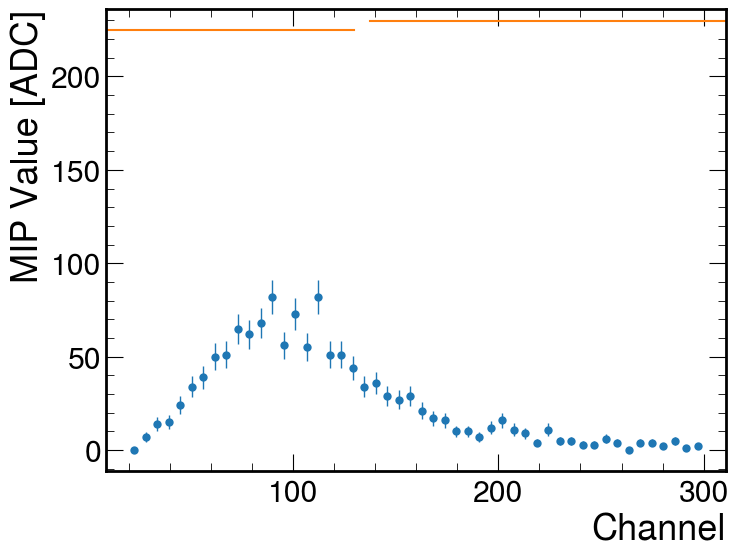

In [9]:
mips = np.array(mips)

# Section 1
section1 = mips[0:16]
excluded_indexes1 = [10, 15]
mask1 = np.ones_like(section1, dtype=bool)
mask1[excluded_indexes1] = False
mips[10] = np.mean(section1[mask1])
mips[15] = np.mean(section1[mask1])

# Section 2
section2 = mips[16:40]
excluded_indexes2 = [2,10,15]
mask2 = np.ones_like(section2, dtype=bool)
mask2[excluded_indexes2] = False
mips[18] = np.mean(section2[mask2])
mips[26] = np.mean(section2[mask2])
mips[31] = np.mean(section2[mask2])

fig = plt.figure( figsize=(8, 6))
#plt.errorbar(range(0,15), mips[0:15], yerr=mipStds[0:15], fmt="o", color = "green")
#plt.errorbar(range(15,16), mips[15:16], yerr=mipStds[15:16], fmt="o", color = "red")
#plt.errorbar(range(16,21), mips[16:21], yerr=mipStds[16:21], fmt="o", color = "blue")
#plt.errorbar(range(21,23), mips[21:23], yerr=mipStds[21:23], fmt="o", color = "purple")
plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")


plt.xlabel('Channel')
plt.ylabel('MIP Value [ADC]')

plt.axhline(y = np.mean(section1[mask1]), color = 'tab:orange', xmax = 16/40)
plt.axhline(y = np.mean(section2[mask2]), color = 'tab:orange', xmin = 17/40)

print("Average mean value:")
print(np.mean(mips))
print("Average width value:")
print(np.mean(mipStds))
print(mips)
print(mipStds)

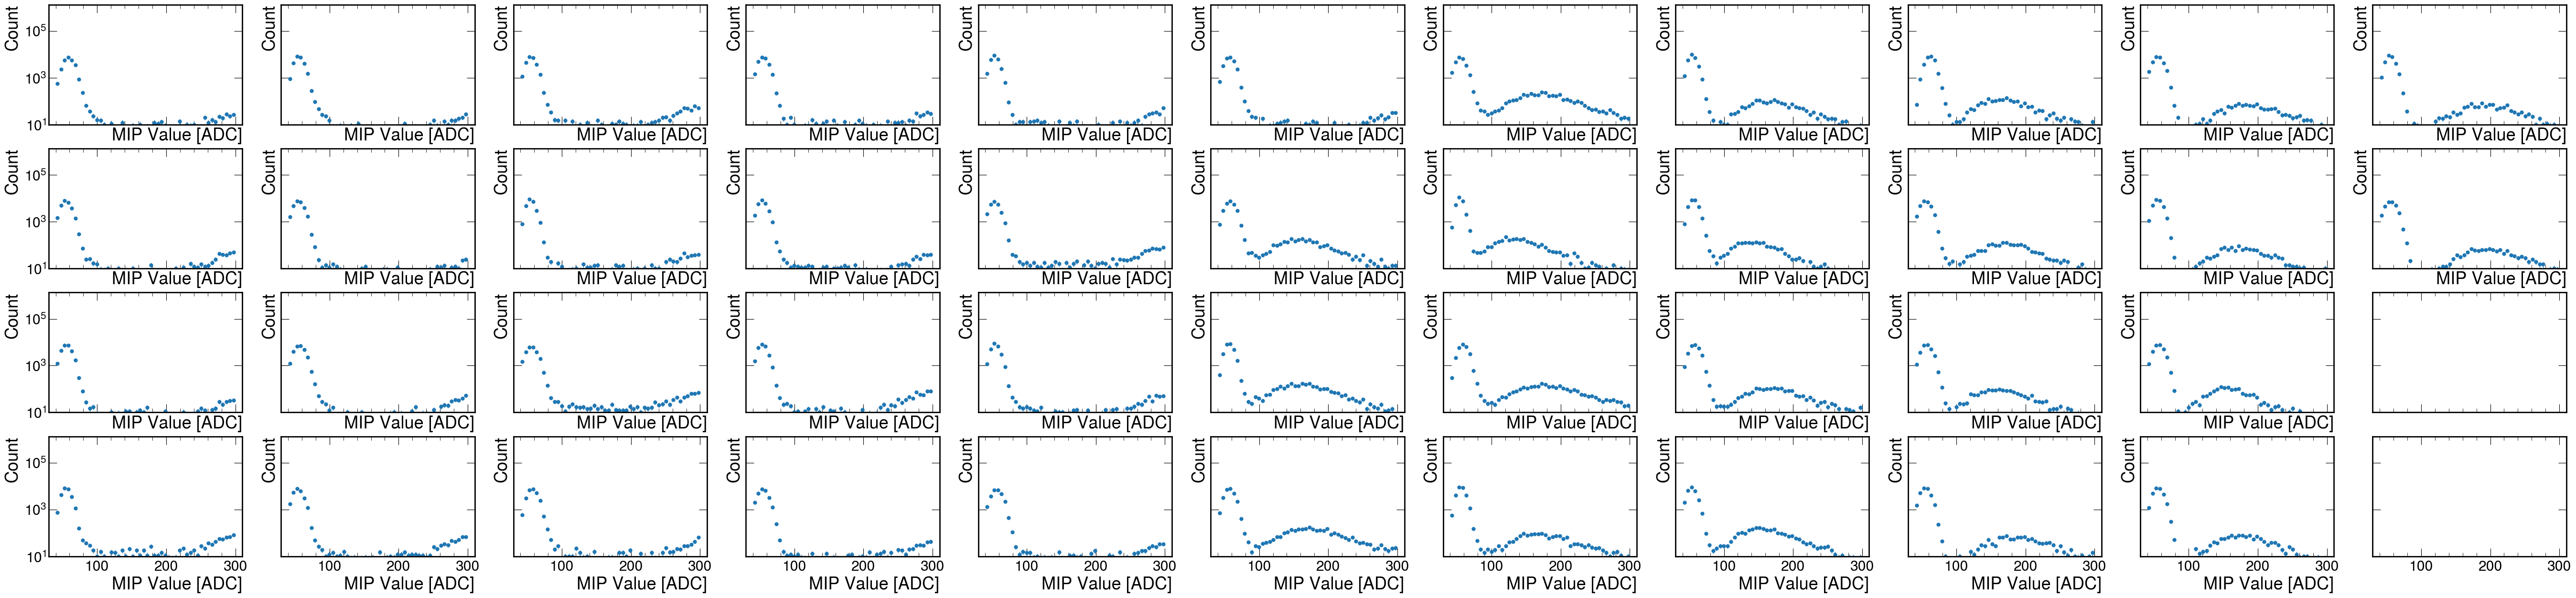

In [10]:
fig, axs=plt.subplots(4, 11, figsize=(0.8*len(cosmic_df.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
#this shows the full spectrum data for each channel for the cosmic ray, shows noise and no cut offs
def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

mips = []
mipStds = []

for i in range(42):
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 40, 300, name="Ptrig"))
    
    cosmicCh = np.array(getattr(cosmic_df,"Ch_{}_LG".format("{:02d}".format(i))))
   
    h.fill(cosmicCh)
    #h.plot(color='tab:blue',label=f"Channel {i} Cosmic Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

    
    data = h.values()[()]
    bins = bin_centers
    plt.ylim(10,1350000)

    plt.ylabel('Count')
    plt.xlabel('MIP Value [ADC]')
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i}Cosmic Data")
    plt.yscale("log")